# Calculating the coherence length and rotation measure for Gaussian turbulent field

This tutorial demonstrates how to the coherence length and rotation measure of a magnetic field with Gaussian turbulence on the example of the Perseus cluster with the central radio galaxy NGC 1275. The assumed B-field environments are the same as in <a href="http://inspirehep.net/record/1432667">Ajello et al. (2016)</a>. 

First some imports:

In [1]:
from gammaALPs.core import Source, ALP, ModuleList
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import simps
from scipy.stats import norm

Next we set the source properties (redshift and sky coordinates), the ALP, and the energy range.
We only need those to init the `ModuleList` later -- we won't actually run the photon-ALP conversion probability calculation here.

In [2]:
ngc1275 = Source(z=0.017559, ra='03h19m48.1s', dec='+41d30m42s')
alp = ALP(m=1., g=1.)

In [3]:
ml = ModuleList(alp, ngc1275)

We add the propagation within the intra-cluster Gaussian turbulent field with the same values as in <a href="http://inspirehep.net/record/1432667">Ajello et al. (2016)</a>.

In [4]:
ml.add_propagation("ICMGaussTurb", 
                  0, # position of module counted from the source. 
                  nsim=1, # number of random B-field realizations
                  B0=10.,  # rms of B field
                  n0=39.,  # normalization of electron density
                  n2=4.05, # second normalization of electron density, see Churazov et al. 2003, Eq. 4
                  r_abell=500., # extension of the cluster
                  r_core=80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4
                  r_core2=280., # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta=1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta2=0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                  eta=0.5, # scaling of B-field with electron denstiy
                  kL=0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012 
                  kH=9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  q=-2.80, # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  seed=0 # random seed for reproducability, set to None for random seed.
                 )

We peek at the transversal magnetic field and the electron density:

Text(0.5, 0, '$r$ (kpc)')

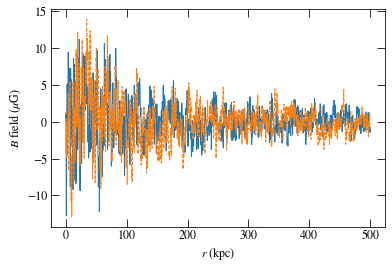

In [5]:
plt.plot(ml.modules["ICMGaussTurb"].r,
         ml.modules["ICMGaussTurb"].B * np.sin(ml.modules["ICMGaussTurb"].psi),
         lw=1)
plt.plot(ml.modules["ICMGaussTurb"].r,
         ml.modules["ICMGaussTurb"].B * np.cos(ml.modules["ICMGaussTurb"].psi),
         lw=1, ls = '--') 
plt.ylabel('$B$ field ($\mu$G)')
plt.xlabel('$r$ (kpc)')

Text(0.5, 0, '$r$ (kpc)')

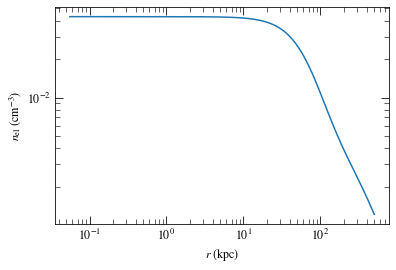

In [6]:
plt.loglog(ml.modules["ICMGaussTurb"].r,ml.modules["ICMGaussTurb"].nel * 1e-3)
plt.ylabel('$n_\mathrm{el}$ (cm$^{-3}$)')
plt.xlabel('$r$ (kpc)')

## Spatial correlation and coherence legnth

The `gammaALPs.bfields.Bgaussian` class has methods to calculate the spatial correlation of the magnetic field and the rotation measure. We can access these methods through the the magnetic field model mehtod, which we can access through `ml.modules['ICMGaussTurb'].Bfield_model`. 

The spatial correlation $C(x_3) = \langle B_\perp(\vec{x}) B_\perp(\vec{x} + x_3 \vec{e}_3)\rangle$ of the transversal magnetic field along the line of sight $z$ is computed like this:

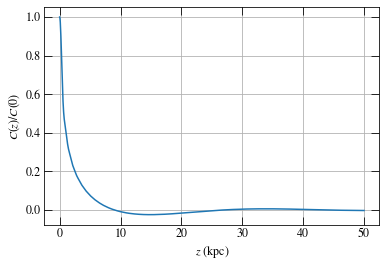

In [7]:
z = np.linspace(0.,50.,1000)  # distance in kpc from cluster center
c = ml.modules["ICMGaussTurb"].Bfield_model.spatial_correlation(z) 

plt.plot(z, c / c[0])
plt.xlabel("$z$ (kpc)")
plt.ylabel("$C(z) / C(0)$")
plt.grid(True)

This is turn can be used to calculate the coherence length of the field, 
$$ \Lambda_C = \frac{1}{C(0)} \int\limits_0^\infty C(z)dz. $$


In [9]:
z = np.linspace(0.,1e3,1000)  # distance in kpc from cluster center
c = ml.modules["ICMGaussTurb"].Bfield_model.spatial_correlation(z) 

Lambda_c = simps(c, z) / c[0]

print ("Coherence length of the field is Lambda_C = {0:.3e} kpc".format(Lambda_c))

Coherence length of the field is Lambda_C = 1.402e+00 kpc


## Calculate the rotation measure of the field

The rotation measure describes the rotation of the polarization vector due to the propagation of an electromagnetic wave through a medium with magnetic field and an electron plasma. 

The change in polarization angle $\Delta\phi$ is proportianol to the wavewavelength and the rotation measure $\mathrm{RM}$ which is given by the integral over the magnetic field parallel to the propagation direction multiplied with the electron density:

$$ \mathrm{RM} \approx 812\,\mathrm{rad}\,\mathrm{m}^{-2} \int\limits_0^z dz' B_{||}(z') n_\mathrm{el}(z'). $$

We can calcluate the $\mathrm{RM}$ through the `ml.modules['ICMGaussTurb'].Bfield_model.rotation_measure` function which computes $B_{||}$ for a requested number `nsim` of random realizations. 
In addition to the line of sight we're interested in, we also have to provide the electron density along $z$ and the scaling of the magnetic field with the electron density, i.e. the factor $(n_\mathrm{el}(z) / n_\mathrm{el}(z=0)^\eta$. The latter can be calculated through the `ml.modules["ICMGaussTurb"].nel_model.Bscale` function. 

We calculate the electron density and the scaling:

In [10]:
n_el = ml.modules["ICMGaussTurb"].nel * 1e-3
Bscale = ml.modules["ICMGaussTurb"].nel_model.Bscale(ml.modules["ICMGaussTurb"].r)

And provide this to the `rotation_measure` function. The loop over the realizations is rather slow, so we calculate the $\mathrm{RM}$ for only 500 random realizations:

In [11]:
ml.modules["ICMGaussTurb"].Bfield_model.seed = 0

t1 = time.time()
nsim=500
rm = ml.modules["ICMGaussTurb"].Bfield_model.rotation_measure(ml.modules["ICMGaussTurb"].r,
                                                              n_el=n_el,
                                                              Bscale=Bscale,
                                                              nsim=nsim)
t2 = time.time()
print("Calculating RM for {0:d} realizations took {1:.2f} seconds".format(nsim, t2 - t1))

Calculating RM for 500 realizations took 34.39 seconds


Finally, we plot the histogram of the $\mathrm{RM}$ values. Since we're assuming a purely turbulent field, we expect a distribution that peaks close to zero and we can compare the spread to the $\mathrm{RM}$ values reported by <a href="https://ui.adsabs.harvard.edu/abs/2006MNRAS.368.1500T/abstract">Taylor et al. (2006)</a> who found RM values between 6500 and 7500 $\mathrm{rad}\,\mathrm{m}^{-2}$.

RM mean +/- sqrt(var) in rad m^-2: 45.00 +/- 2787.36


Text(0, 0.5, 'Density')

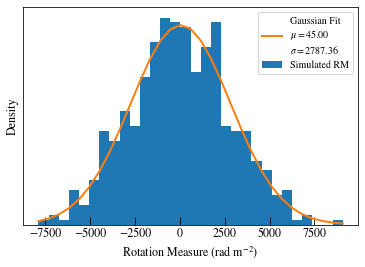

In [12]:
n, bins, _ =  plt.hist(np.sort((rm)), bins=30, density=True, label="Simulated RM")

mean = np.mean(rm)  # mean
var = np.var(rm)  # variance
print("RM mean +/- sqrt(var) in rad m^-2: {0:.2f} +/- {1:.2f}".format(mean, np.sqrt(var)))

plt.plot(bins, norm.pdf(bins, loc=mean, scale=np.sqrt(var)),
         lw=2,
         label="Gaussian Fit\n$\mu = {0:.2f}$\n$\sigma={1:.2f}$".format(mean, np.sqrt(var)))

plt.legend()
plt.gca().tick_params(labelleft=False,  left=False, right=False, top=False)
plt.xlabel("Rotation Measure (rad m${}^{-2}$)")
plt.ylabel("Density")

With our chosen $B$ field, $\sigma(\mathrm{RM}) \sim 2800 \,\mathrm{m}^{-2}$.